# Chapter 1. Gaining Early Insights from Textual Data

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import random

import seaborn as sns
sns.set()

In [2]:
DATASET = Path("../DATASETS/1/un-general-debates-blueprint.csv")

In [3]:
df = pd.read_csv(DATASET)
df.sample(4)

,session,year,country,country_name,speaker,position,text
1034,33,1978,LAO,Lao People's Democratic Republic,Boupha,NaN,"﻿73.\tMr. President, allow me, on behalf of th..."
4002,52,1997,JAM,Jamaica,Percival James Patterson,Prime Minister,"﻿Mr. President, your\nelection to preside over..."
861,32,1977,ESP,Spain,OREJA AGUIRRE,NaN,"﻿141.\t Mr. President, my first words will be ..."
737,31,1976,GRD,Grenada,Mr; Eric Gairy,Prime Minister,"Let your light so shine before men, that they ..."


## Getting an overview of the Data with pandas

* Calculate summary statistics.
* Check for missing values.
* Plot distributions of interesting attributes.
* Compare distributions across categories.
* Visualize developments over time.

### Calculating Summary Statistics for Columns

In [4]:
df["length"] = df["text"].str.len()
df.describe().T # dataset contain speaches from the 25th to the 70th un debates (1970 - 2015)

,count,mean,std,min,25%,50%,75%,max
session,7507.0,49.610763,12.892155,25.0,39.0,51.0,61.0,70.0
year,7507.0,1994.610763,12.892155,1970.0,1984.0,1996.0,2006.0,2015.0
length,7507.0,17967.281604,7860.038463,2362.0,12077.0,16424.0,22479.5,72041.0


In [6]:
df[["country", "speaker"]].describe(include='O').T # The dataset contain 199 unique countries & 

,count,unique,top,freq
country,7507,199,ALB,46
speaker,7480,5428,Seyoum Mesfin,12


In [7]:
# Checking missing values

df.isna().sum()

session            0
year               0
country            0
country_name       0
speaker           27
position        3005
text               0
length             0
dtype: int64

In [8]:
# we need to replace the missing value with some generic values

df['speaker'].fillna("unknown", inplace=True)

In [9]:
# there is a chance, the speaker's name is spelled differently.
df[df['speaker'].str.contains('Bush')]['speaker'].value_counts()

George W. Bush        4
Mr. George W. Bush    2
Bush                  1
George Bush           1
Mr. George W Bush     1
Name: speaker, dtype: int64

In [20]:
df[df['speaker'].str.contains('Bush')]['speaker'].value_counts()

George W. Bush        4
Mr. George W. Bush    2
Bush                  1
George Bush           1
Mr. George W Bush     1
Name: speaker, dtype: int64

### Plotting Value Distributions

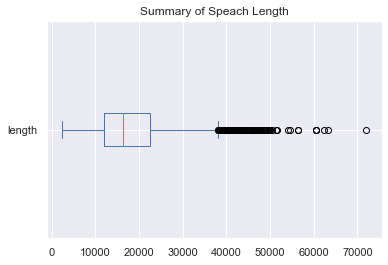

In [257]:
df["length"].plot(kind="box", vert=False, title="Summary of Speach Length");
# 50% of the speaches have a length rougly 12000 and 22000, with the median at about 16000.

<AxesSubplot:ylabel='Frequency'>

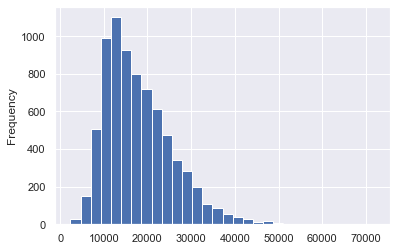

In [258]:
df["length"].plot(kind="hist", bins=30)

### Comparing Value Distributions Across Categories

In [259]:
# Peculiarities in the data often become visible when different subsets of the data are examined

where = df['country'].isin(['USA', 'FRA', 'GBR', 'CHN', 'RUS', 'IND'])

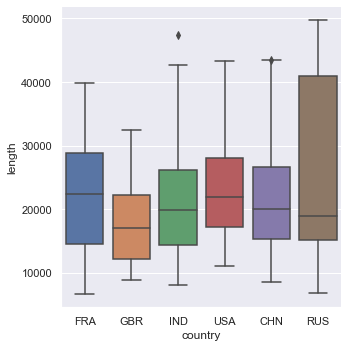

In [260]:
sns.catplot(data=df[where], x='country', y='length', kind='box');

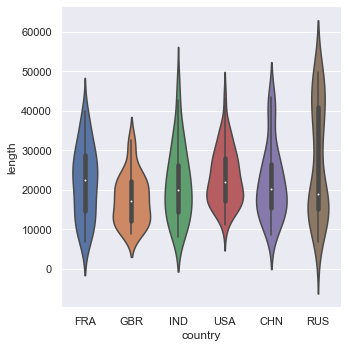

In [261]:
sns.catplot(data=df[where], x='country', y='length', kind='violin')
# RUS is much larger than for GBR but existence of multiple peaks, 
# as in Russia, only becomes apparent in the violin plot.

### Visualizing Developments Over Time

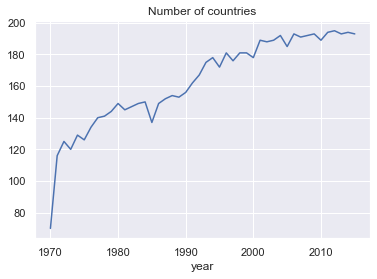

In [262]:
df.groupby('year').size().plot(title="Number of countries");

# this reflects the development of UN in each year.

<AxesSubplot:title={'center':'Avg. Speech Length'}, xlabel='year'>

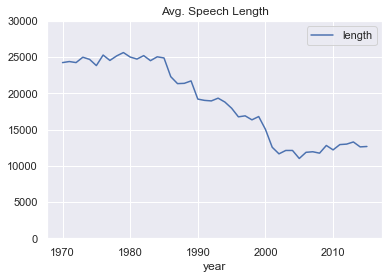

In [263]:
df.groupby('year').agg({'length': 'mean'}).plot(title="Avg. Speech Length", ylim=(0,30000))

#the speech length needed to decrease with more countries entering the debates

## Building a Simple Text Preprocessing Pipeline


### Performing Tokenization with Regular Expressions

In [264]:
import regex as re

def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

In [265]:
text = "Let's defeat SARS-CoV-2 together in 2020!"
tokens = tokenize(text)
print("|".join(tokens))

Let|s|defeat|SARS-CoV-2|together|in


### Treating Stopwords

In [266]:
import nltk

stopwords = set(nltk.corpus.stopwords.words('english'))

In [267]:
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

In [268]:
include_stopwords = {"dear", "regards", "must", "would", "also"}
exclude_stopwords = {"against"}

stopwords |= include_stopwords
stopwords -= exclude_stopwords

### Processing a Pipeline with One Line of Code

In [269]:
pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [270]:
df['tokens'] = df['text'].apply(prepare, pipeline=pipeline)

In [271]:
df['num_tokens'] = df['tokens'].map(len)

## Blueprints for Word Frequency Analysis

### Counting Words with a Counter

In [272]:
from collections import Counter

In [273]:
tokens = tokenize("She likes my cats and my cats like my sofa")

In [274]:
counter = Counter(tokens)
print(counter)

Counter({'my': 3, 'cats': 2, 'She': 1, 'likes': 1, 'and': 1, 'like': 1, 'sofa': 1})


In [275]:
# Counter can be incrementally updated

more_token = tokenize("She likes my dogs too")
counter.update(more_token)

In [276]:
print(counter)

Counter({'my': 4, 'She': 2, 'likes': 2, 'cats': 2, 'and': 1, 'like': 1, 'sofa': 1, 'dogs': 1, 'too': 1})


In [277]:
counter = Counter()

df['tokens'].map(counter.update)

0       None
1       None
2       None
3       None
4       None
        ... 
7502    None
7503    None
7504    None
7505    None
7506    None
Name: tokens, Length: 7507, dtype: object

In [278]:
print(counter.most_common(4))

[('nations', 124508), ('united', 120763), ('international', 117223), ('world', 89421)]


In [279]:
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into a DataFrame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'

    return freq_df.sort_values('freq', ascending=False)

In [280]:
freq_df = count_words(df)
freq_df.head(5)

,freq
token,
nations,124508
united,120763
international,117223
world,89421
countries,85734


In [281]:
count_words(df, column='text', 
        preprocess=lambda text: re.findall(r"\w{10,}", text))

,freq
token,
international,106974
development,51334
Government,35528
Organization,33763
developing,25177
...,...
enfranchising,2
interrelate,2
compositions,2


### Creating a Frequency Diagram

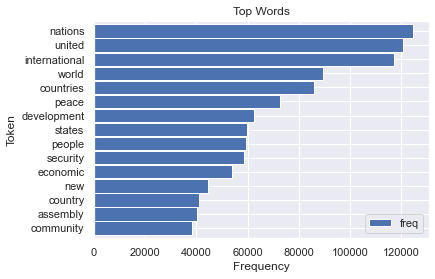

In [282]:
ax = freq_df.head(15).plot(kind="barh", width=.95)

ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words');

### Creating Word Clouds

In [283]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

In [284]:
text = df.query("year==2015 and country=='USA'")['text'].values[0]

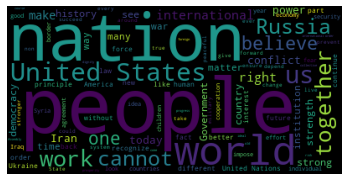

In [285]:
wc = WordCloud(max_words=100, stopwords=stopwords)
wc.generate(text)

plt.imshow(wc)
plt.axis("off");

In [286]:
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400,
                   background_color= "black", colormap="Paired",
                   max_font_size=150, max_words=max_words)

    # convert DataFrame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items()
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)

    plt.title(title)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

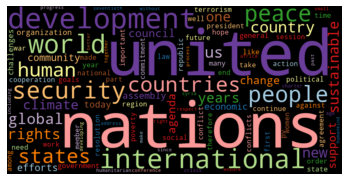

In [287]:
freq_2015_df = count_words(df[df['year']==2015])
plt.figure()
wordcloud(freq_2015_df['freq'], max_words=100)

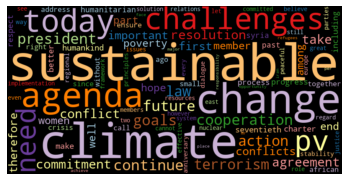

In [288]:
wordcloud(freq_2015_df['freq'], max_words=100, stopwords=freq_df.head(50).index)

### Ranking with TF-IDF

In [309]:
def compute_idf(df, column='tokens', preprocess=None, min_df=2):

    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))

    # count tokens
    counter = Counter()
    df[column].map(update)

    # create DataFrame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query('df >= @min_df')
    idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
    idf_df.index.name = 'token'
    return idf_df

In [310]:
idf_df = computer_idf(df)

C:\Users\HP\AppData\Local\Temp/ipykernel_11852/831539297.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log(len(df)/idf_df['df'])+.1


In [311]:
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

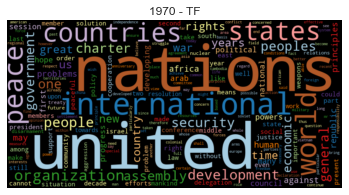

In [312]:
freq_1970 = count_words(df[df['year'] == 1970])
freq_2015 = count_words(df[df['year'] == 2015])

freq_1970['tfidf'] = freq_1970['freq'] * idf_df['idf']
freq_2015['tfidf'] = freq_2015['freq'] * idf_df['idf']

#wordcloud(freq_df['freq'], title='All years', subplot=(1,3,1))
wordcloud(freq_1970['freq'], title='1970 - TF',
          stopwords=['twenty-fifth', 'twenty-five'])

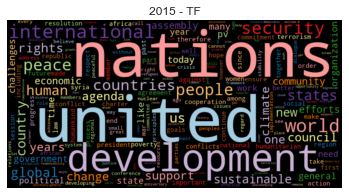

In [313]:
wordcloud(freq_2015['freq'], title='2015 - TF',
          stopwords=['seventieth'])

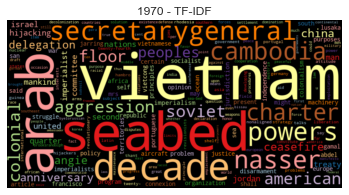

In [314]:
wordcloud(freq_1970['tfidf'], title='1970 - TF-IDF',
          stopwords=['twenty-fifth', 'twenty-five', 'twenty', 'fifth'])

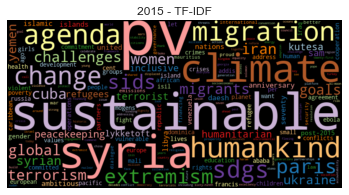

In [315]:
wordcloud(freq_2015['tfidf'], title='2015 - TF-IDF',
          stopwords=['seventieth'])

### Finding a Keyword-in-context

In [316]:
from textacy.extract.kwic import keyword_in_context

In [317]:

def kwic(doc_series, keyword, window=35, print_samples=5):

    def add_kwic(text):
        kwic_list.extend(keyword_in_context(text, keyword, ignore_case=True,
                              window_width=window))

    kwic_list = []
    doc_series.map(add_kwic)

    if print_samples is None or print_samples==0:
        return kwic_list
    else:
        k = min(print_samples, len(kwic_list))
        print(f"{k} random samples out of {len(kwic_list)} " + \
              f"contexts for '{keyword}':")
        for sample in random.sample(list(kwic_list), k):
            print(re.sub(r'[\n\t]', ' ', sample[0])+'  '+ \
                  sample[1]+'  '+\
                  re.sub(r'[\n\t]', ' ', sample[2]))

In [318]:
kwic(df[df['year'] == 2015]['text'], 'pv', print_samples=5, window=10)

5 random samples out of 468 contexts for 'pv':
2015 A/70/  PV  .22 agains
2015 A/70/  PV  .19 of the
orld.” (A/  PV  .22, p. 32
2015 A/70/  PV  .25 feed t
(see A/70/  PV  .13) — a d


In [319]:
kwic(df[df['year'] == 2015]['text'], 'sdgs', print_samples=5, window=10)

5 random samples out of 73 contexts for 'sdgs':
on of the   SDGs  . The Comm
on of the   SDGs  . We there
 with the   SDGs   just adop
under the   SDGs  . In 2009,
arget the   SDGs  , then my 


### Analysing N-Grams

In [320]:
def ngrams(tokens, n=2, sep=" "):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])]


In [321]:
text = "the visible manifestation of the global climate change"
tokens = tokenize(text)

In [322]:
print(" | ".join(ngrams(tokens, 2)))

the visible | visible manifestation | manifestation of | of the | the global | global climate | climate change


In [323]:
def ngrams(tokens, n=2, sep=" ", stopwords=set()):
    ngram = [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])
            if len([t for t in ngram if t in stopwords])==0]
    return ngram

In [324]:
print("Bigrams:", " | ".join(ngrams(tokens, 2, stopwords=stopwords)))
print("Trigrams:", " | ".join(ngrams(tokens, 3, stopwords=stopwords)))

Bigrams: visible manifestation | global climate | climate change
Trigrams: global climate change


In [325]:
df['bigrams'] = df['text'].apply(prepare, pipeline=[str.lower, tokenize]) \
                          .apply(ngrams, n=2, stopwords=stopwords)

count_words(df, 'bigrams').head(5)

,freq
token,
united nations,103236
international community,27786
general assembly,27096
security council,20961
human rights,19856


In [326]:
idf_df = pd.concat([idf_df, compute_idf(df, "bigrams", min_df=10)])
freq_df = count_words(df[df['year'] == 2015], 'bigrams')
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

C:\Users\HP\AppData\Local\Temp/ipykernel_11852/1930029238.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1


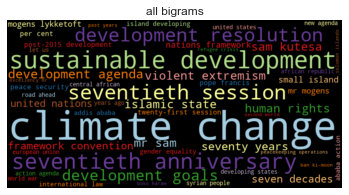

In [327]:
wordcloud(freq_df['tfidf'], title='all bigrams', max_words=50)

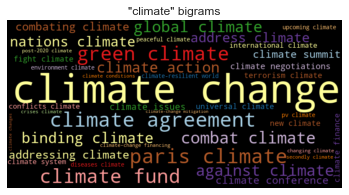

In [328]:
where = freq_df.index.str.contains("climate")
wordcloud(freq_df[where]['freq'], title='"climate" bigrams', max_words=50)

## Comparing Frequencies Across Time Intervals and Categories

### Creating Frequency Timelines

In [340]:
def count_keywords(tokens, keywords):
    tokens = [t for t in tokens if t in keywords]
    counter = Counter(tokens)
    return [counter.get(k, 0) for k in keywords]

In [341]:
keywords = ['nuclear', 'terrorism', 'climate', 'freedom']
tokens = ['nuclear', 'climate', 'climate', 'freedom', 'climate', 'freedom']


In [342]:
print(count_keywords(tokens, keywords))

[1, 0, 3, 2]


In [349]:
def count_keywords_by(df, by, keywords, column='tokens'):

    freq_matrix = df[column].apply(count_keywords, keywords=keywords)
    freq_df = pd.DataFrame.from_records(freq_matrix, columns=keywords)
    freq_df[by] = df[by] # copy the grouping column(s)

    return freq_df.groupby(by=by).sum().sort_values(by)

In [350]:
freq_df = count_keywords_by(df, by='year', keywords=keywords)

In [352]:
freq_df.head(4)

,nuclear,terrorism,climate,freedom
year,,,,
1970,192,7,18,128
1971,275,9,35,205
1972,393,379,74,280
1973,347,124,79,266


In [353]:
freq_df.tail(4)

,nuclear,terrorism,climate,freedom
year,,,,
2012,254,198,340,305
2013,260,216,349,177
2014,144,404,654,129
2015,246,378,662,148


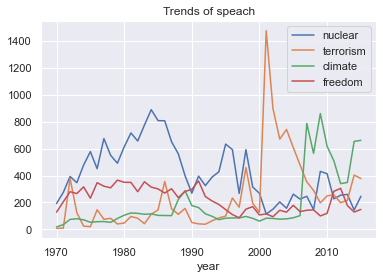

In [360]:
freq_df.plot(kind="line", title="Trends of speach");

### Creating Frequency Heatmap


In [362]:
keywords = ['terrorism', 'terrorist', 'nuclear', 'war', 'oil',
            'syria', 'syrian', 'refugees', 'migration', 'peacekeeping',
            'humanitarian', 'climate', 'change', 'sustainable', 'sdgs', 'india']

In [363]:
freq_df = count_keywords_by(df, by='year', keywords=keywords)

In [364]:
# compute relative frequencies based on total number of tokens per year
freq_df = freq_df.div(df.groupby('year')['num_tokens'].sum(), axis=0)

In [365]:
# apply square root as sublinear filter for better contrast
freq_df = freq_df.apply(np.sqrt)


In [ ]:
sns.heatmap(data=freq_df.T,
            xticklabels=True, yticklabels=True, cbar=False, cmap="Reds")